# Titanic Survival Prediction — End-to-End ML (Portfolio)

**Goal:** Predict passenger survival on the Titanic using multiple models and compare their performance.

**Dataset:** Kaggle — *Titanic: Machine Learning from Disaster* (link provided in README).

**What this notebook covers**
* Data understanding & cleaning (missing values, encoding)
* Feature engineering (selected signals for tabular modeling)
* Baseline model, Logistic Regression model and tree-based models (Decision Tree, Random Forest)
* Evaluation with Accuracy, Precision, Recall, F1, ROC-AUC, Confusion Matrix
* Model interpretation (feature importances)
* Saving trained models for later reuse


**Tech stack:** Python · pandas · scikit-learn · matplotlib/seaborn

> TL;DR: On this dataset, **Random Forest** delivered the best balance of metrics (AUC ≈ 0.83), with **Sex**, **Fare**, and **Age** as key predictors.


## 1. Import libraries and load data
We start by importing the main data analysis and visualization libraries (pandas, numpy, seaborn, matplotlib)
and loading the Titanic dataset. The goal is to predict who survived the disaster.


In [151]:
# Basic tools for data analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, precision_recall_fscore_support, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib

In [152]:
import os, pathlib
PROJECT_DIR = pathlib.Path(".").resolve()
DATA_DIR = PROJECT_DIR  # train.csv/test.csv are next to the notebook
MODELS_DIR = PROJECT_DIR / "models"
IMAGES_DIR = PROJECT_DIR / "images"
MODELS_DIR.mkdir(exist_ok=True); IMAGES_DIR.mkdir(exist_ok=True)

TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH  = DATA_DIR / "test.csv"

In [153]:
df = pd.read_csv(TRAIN_PATH)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Data exploration (EDA)
We explore column meanings, check missing values, and understand class balance.

In [154]:
# Basic checks
df.info()         # see types and non-null counts
df.isna().sum()   # count missing values
df.describe()     # numerical summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [155]:
# Class balance
df['Survived'].value_counts(normalize=True)

,proportion
Survived,
0,0.616162
1,0.383838


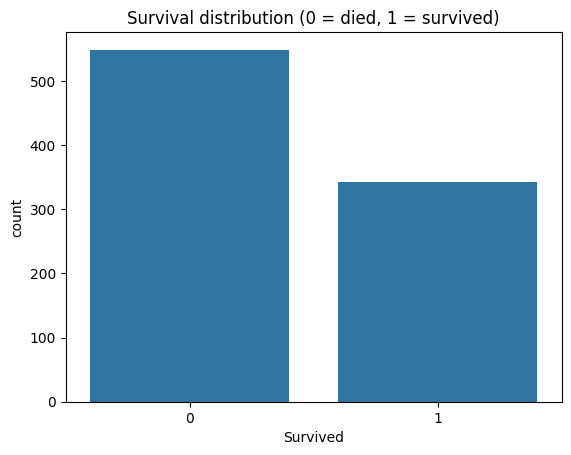

In [156]:
# Quick visual exploration (EDA)

# Class balance
sns.countplot(x='Survived', data = df)
plt.title('Survival distribution (0 = died, 1 = survived)')
plt.show()

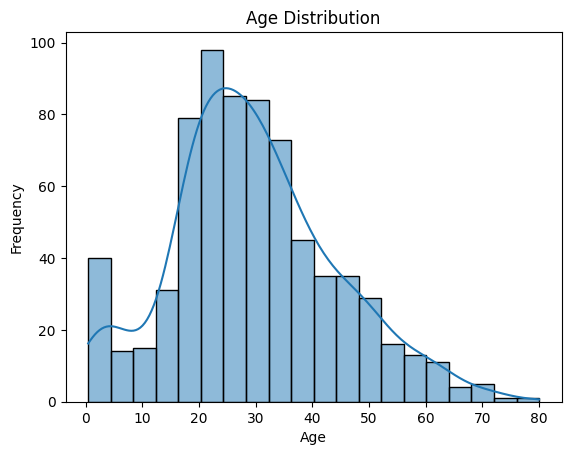

In [157]:
# Age distribution
sns.histplot(df["Age"], bins = 20, kde = True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

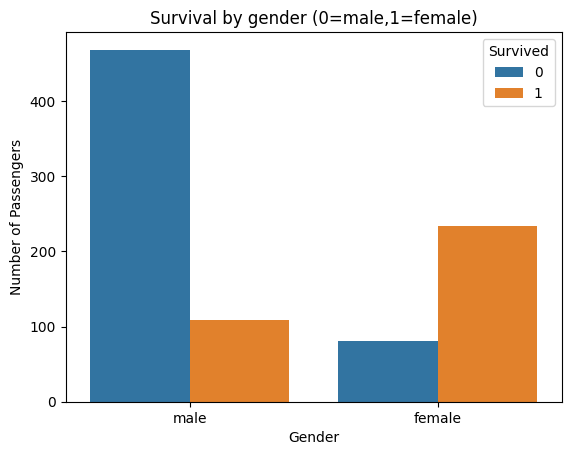

In [158]:
# Survival by Gender
sns.countplot(x='Sex', hue = 'Survived', data=df)
plt.title("Survival by gender (0=male,1=female)")
plt.ylabel("Number of Passengers")
plt.xlabel("Gender")
plt.show()

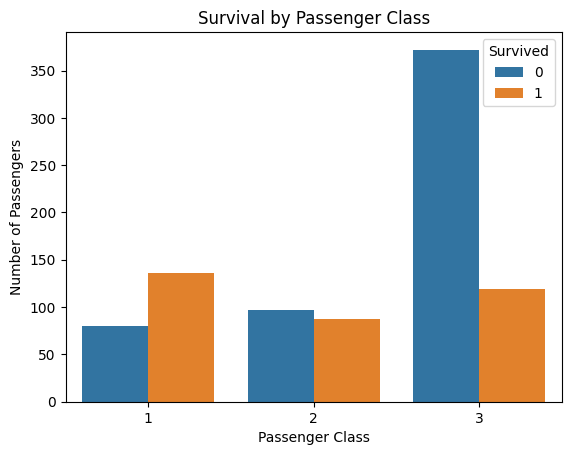

In [159]:
# Survival by Passenger Class
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Survival by Passenger Class')
plt.ylabel('Number of Passengers')
plt.xlabel('Passenger Class')
plt.show()

From these charts, we can see that women and first-class passengers had much higher survival rates.
Age is spread mostly between 20–40 years, with a few elderly passengers.

### **Titanic Data Understanding**


In [160]:
print("Shape", df.shape)
display(df.head(3))
display(df.info())
print("\nMissing Values", df.isna().sum())
print("\nTarget Balance", df["Survived"].value_counts(normalize=True))

Shape (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None


Missing Values PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Target Balance Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


**Observation:**

Dataset has 891 rows x 12 columns

Target = `Survived` (binary classification)

Key predictors likely: Sex, Pclass, Fare, Age

Missing Values in Age (177), Cabin (687), Embarked (2)

Classes slightly imbalanced (62% -> 0, 38% -> 1)

## 3. Data preprocessing and feature engineering

We cleaned missing values, encoded categorical variables, and scaled numeric features where needed.  
Target variable: `Survived` (0 = not survived, 1 = survived)

In [161]:
# Most frequent value in Embarked column
df["Embarked"].value_counts()

,count
Embarked,
S,644
C,168
Q,77


In [162]:
# Fill missing values with the most frequent value, which is S
df["Embarked"]= df["Embarked"].fillna("S")

In [163]:
print(df["Embarked"].isna().sum())

0


In [164]:
# Convert Cabin into a Binary Feature
df["HasCabin"] = df["Cabin"].notna().astype(int)
df.drop(columns = ["Cabin"], inplace = True)

In [165]:
df["HasCabin"].value_counts()

,count
HasCabin,
0,687
1,204


HasCabin feature new values: 0 - No Cabin, 1 - Has Cabin

In [166]:
# Median of Age
df["Age"].median()

28.0

In [167]:
# Replace Missing Values in Age Column with Median
df["Age"] = df["Age"].fillna(df["Age"].median())

In [168]:
print(df["Age"].isna().sum())

0


Missing values replaced by median age in Age Column

In [169]:
# Drop useless columns
df.drop(columns = ["PassengerId", "Name", "Ticket"], inplace = True)

In [170]:
# Quick check
df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0
HasCabin,0


### **Data Preprocessing Summary**

Filled missing `Embarked` with the most frequent "S"

Filled missing `Age` with median

Converted `Cabin` to Binary Feature (0/1)

Dropped irrelevant columns `PassengerId`, `Name`, `Ticket`

### **Encoding Categorical Variables**

In [171]:
# Encode Sex column
df["Sex_num"] = df["Sex"].map({"male":0, "female":1})
print(df['Sex_num'].head())

0    0
1    1
2    1
3    1
4    0
Name: Sex_num, dtype: int64


In [172]:
# Encode Embarked column
df = pd.get_dummies(df, columns = ["Embarked"], drop_first = True)

In [173]:
# Check current columns
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'HasCabin', 'Sex_num', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [174]:
# Check how df looks like now
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,HasCabin,Sex_num,Embarked_Q,Embarked_S
0,0,3,male,22.0,1,0,7.2500,0,0,False,True
1,1,1,female,38.0,1,0,71.2833,1,1,False,False
2,1,3,female,26.0,0,0,7.9250,0,1,False,True
3,1,1,female,35.0,1,0,53.1000,1,1,False,True
4,0,3,male,35.0,0,0,8.0500,0,0,False,True


In [175]:
# Drop Sex column as we have Sex_num
df.drop(columns = "Sex", inplace = True)

In [176]:
# Convert Embarked_Q and Embarked_S to 0/1
df["Embarked_Q"] = df["Embarked_Q"].astype(int)
df["Embarked_S"] = df["Embarked_S"].astype(int)

In [177]:
# Quick check
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,HasCabin,Sex_num,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,0,0,1
1,1,1,38.0,1,0,71.2833,1,1,0,0
2,1,3,26.0,0,0,7.9250,0,1,0,1
3,1,1,35.0,1,0,53.1000,1,1,0,1
4,0,3,35.0,0,0,8.0500,0,0,0,1


### **Encoding Summary**
Encoded Embarked column to Embarked_Q and Embarked_S and turned Boolean to 0/1

Encoded Sex Column to 0/1 where male = 0, female = 1

## 4. Feature-target split and train-test split
We separate the target variable (Survived) from the features and create train/test sets.


In [178]:
# Choosing target and features
X = df.drop(columns = "Survived") # table of features
y = df["Survived"] # single column with 0 or 1 (survival)

In [179]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

`X_train` = features for training

`X_test` = features for testing that will be tested later

`y_train` = correct answers (`Survived`) for those passengers

`y_test` = correct answers for test passengers

`stratify = y` used so the balance (0s and 1s) remains the same in both parts

## 5. Baseline model
We train a dummy classifier to see the performance of random guessing.


In [180]:
# Build a "dumb" model to see if real models are better
dummy = DummyClassifier(strategy = "most_frequent")
dummy.fit(X_train, y_train)
baseline_acc = dummy.score(X_test, y_test)
print("Baseline Accuracy: ", baseline_acc)

Baseline Accuracy:  0.6145251396648045


Baseline accuracy here indicates that if we always said "everyone died", we'd be right 61.45% of the time.

## 6. Logistic Regression model
We train our first real model and evaluate it with accuracy, F1, and confusion matrix.


In [181]:
# Import and train
log_reg = LogisticRegression(max_iter = 1000, n_jobs = None) #max_iter gives the solver enough steps to converge
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### **Predict Labels and Probabilities**


In [182]:
# Predict Class (0/1): the model's final yes/no decision
y_pred = log_reg.predict(X_test)

# Predict Probability of Class 1 (Survive): number from 0 to 1
y_proba = log_reg.predict_proba(X_test)[:, 1]

# Check a few
print("First 5 predicted classes: ", y_pred[:5])
print("First 5 predicted probabilities:", np.round(y_proba[:5], 3))

First 5 predicted classes:  [0 0 0 0 1]
First 5 predicted probabilities: [0.072 0.049 0.159 0.038 0.67 ]


prob = 0.072 -> predict 0 (died) = 7.2% chance to survive

prob = 0.049 -> predict 0 (died) = 4.9% chance to survive

prob = 0.159 -> predict 0 (died) = 15.9% chance to survive

prob = 0.038 -> predict 0 (died) = 3.8% chance to survive

prob = 0.67 -> predict 1 (survived) = 67% chance to survive

### **Metrics: Accuracy, Precision, Recall, F1, Confusion Matrix**

In [183]:
# Basic scores
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division = 0) # when we say survived, how often are we right?
rec = recall_score(y_test, y_pred, zero_division = 0) # of all real survivors, how many did we catch?
f1 = f1_score(y_test, y_pred, zero_division = 0) # balance of prec and rec

# Check results
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

Accuracy: 0.804
Precision: 0.774
Recall: 0.696
F1-score: 0.733


In [184]:
# Detailed Report Per Class (0 and 1)
print("Classification Report:\n", classification_report(y_test, y_pred, digits = 3, zero_division = 0))

Classification Report:
               precision    recall  f1-score   support

           0      0.821     0.873     0.846       110
           1      0.774     0.696     0.733        69

    accuracy                          0.804       179
   macro avg      0.797     0.784     0.789       179
weighted avg      0.803     0.804     0.802       179




Confusion Matrix:
 [[96 14]
 [21 48]]


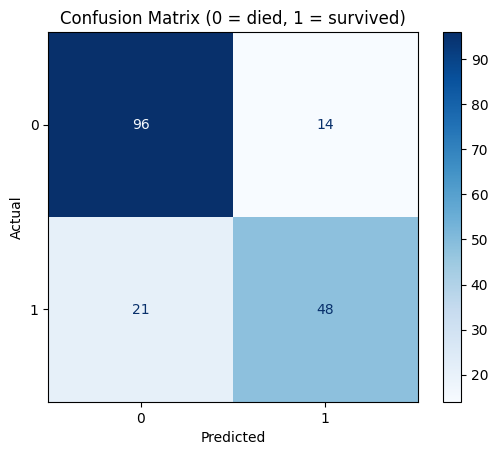

In [185]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels = [0,1])
print("\nConfusion Matrix:\n", cm)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1])
disp.plot(cmap = "Blues", values_format = "d")
plt.title("Confusion Matrix (0 = died, 1 = survived)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

### **Metrics Summary**

Confusion Matrix

[[TN 96, FP 14],
                  
[FN 21, TP 48]]

TN (True Negative): model said 0 (died) and they really died

FP (False Positive): model said 1 (survived) but they died = False Alarm

FN (False Negative): model said 0 (died) but they survived = Missed Survivor

TP (True Positive): model said 1 (survived) and they really survived

**Accuracy**: 0.804 means we're right 80% overall

**Precision**: 0.774 means we're right 77% when we say "Survived"

**Recall**: 0.696 means we catch aprox 69.6% of true survivors

**F1-score**: 0.733 = balance of precision and recall is high 73.3%

### **Model interpretation (feature importance)**
We look at coefficients to see which factors most influence survival.

Positive = increases chance to survive.

Negative = decreases chance to survive.

Bigger absolute value = stronger effect.

In [186]:
# Map each coefficient to its feature name
coef = pd.Series(log_reg.coef_[0], index = X.columns)
coef.sort_values(ascending = False)
print("\nLogistic Regression Coefficients:\n")
print(coef)


Logistic Regression Coefficients:

Pclass       -0.828756
Age          -0.039091
SibSp        -0.239635
Parch        -0.084555
Fare          0.001375
HasCabin      0.842653
Sex_num       2.558902
Embarked_Q    0.277652
Embarked_S   -0.358319
dtype: float64


`Pclass` negative coefficient -0.828756 means higher the class number, the lower survival chance.

`Age` has slight negative coefficient -0.039091 meaning that older passengers are less likely to survive.

`SibSp` has negative coefficient -0.239635 meaning that more siblings/spouses = lower survival.

`Parch` slight negative coefficient -0.084555 means having parents/ children reduces survival chance.

`Fare` has tiny positive coefficient which means higher fare = wealthier = slightly better survival chance.

`HasCabin` has strong positive coefficient 0.842653 which means having a cabin increases survival chance (were closer to deck).

`Sex_num` strongest positive coefficient 2.558902 (females = 1, males = 0) suggests that being female increases survival odds dramatically.

`Embarked_Q` slight positive coefficient 0.277652 means passengers from Queenstown have slightly higher survival chance.

`Embarked_S` slight negative coefficient -0.358319 = many passengers from Southampton had a slightly lower survival chance.



### **ROC–AUC & ROC Curve** (Threshold-free quality)
We measure how well the model can separate survivors vs non-survivors across all thresholds (not just 0.5).

AUC = 0.5 means random guessing; AUC close to 1.0 means strong separation.

The ROC curve shows the trade-off: TPR (Recall) vs FPR for many thresholds.

ROC-AUC:  0.8408432147562582


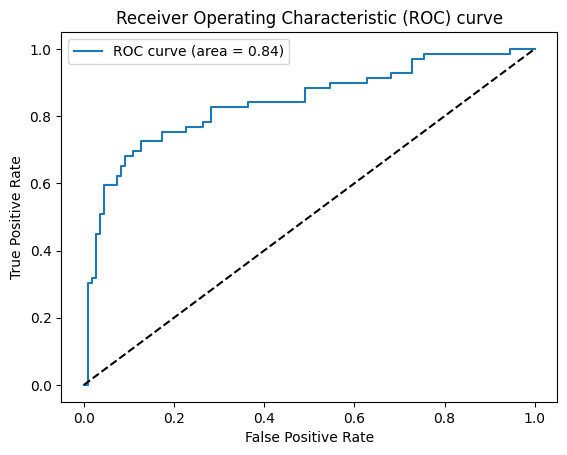

In [187]:
# Calculate AUC
auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC: ", auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC curve (area = {auc:.2f})")  # our curve
plt.plot([0,1], [0,1], 'k--')  # diagonal line = random model
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend()
plt.show()

ROC-AUC shows how well the model separates survivors vs non-survivors.

AUC = 0.84 and the curve is bowed toward top-left which means a good separation.

### **Decision Threshold Tuning** (Precision ↔ Recall trade-off)

The default decision rule is prob ≥ 0.5 ⇒ Survived.

We test custom thresholds (0.3, 0.4, 0.5, 0.6) to see how Precision and Recall move.

In [188]:
for thr in [0.3, 0.4, 0.5, 0.6]:
  pred_thr = (y_proba >= thr).astype(int)
  p, r, f1, _ = precision_recall_fscore_support(y_test, pred_thr, average = "binary", zero_division = 0)
  print(f"thr={thr:.1f}  precision={p:.1f}  recall={r:.1f}  f1={f1:.1f}")

thr=0.3  precision=0.6  recall=0.8  f1=0.7
thr=0.4  precision=0.7  recall=0.8  f1=0.7
thr=0.5  precision=0.8  recall=0.7  f1=0.7
thr=0.6  precision=0.8  recall=0.6  f1=0.7


Lower threshold → we label more people as “survived” → Recall↑, Precision↓.

Higher threshold → we label fewer as “survived” → Precision↑, Recall↓.

If missing a survivor is very bad → lower threshold (favor Recall).

If false “survived” is costly → raise threshold (favor Precision).

### **Cross-Validation**
We train/evaluate the model on multiple folds to check stability.

If accuracy is similar across folds, the model is robust (not just lucky on one split).

In [189]:
cv = cross_val_score(LogisticRegression(max_iter=1000), X, y, cv = 5, scoring = "accuracy")
print("CV Accuracy: ", cv)
print("CV Mean: ", cv.mean())

CV Accuracy:  [0.79888268 0.78089888 0.78651685 0.7752809  0.82022472]
CV Mean:  0.7923608059757705


Shows the list of fold scores and the mean.

We have consistent scores (small variation) means its a healthy model.

### **Pipeline with scaler**

In [190]:
# Pipeline with scaler
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe.fit(X_train, y_train)

# Predictions for the pipeline
y_pred_pipe  = pipe.predict(X_test)
y_proba_pipe = pipe.predict_proba(X_test)[:, 1]

# Metrics for the pipeline
acc_pipe = accuracy_score(y_test, y_pred_pipe)
f1_pipe  = f1_score(y_test, y_pred_pipe)
auc_pipe = roc_auc_score(y_test, y_proba_pipe)

print(f"LogReg + Scaler = Accuracy: {acc_pipe:.3f} | F1: {f1_pipe:.3f} | ROC-AUC: {auc_pipe:.3f}")

LogReg + Scaler = Accuracy: 0.816 | F1: 0.748 | ROC-AUC: 0.841


We build a pipeline that automatically scales the data before training.

`StandardScaler` adjusts all numeric features to the same scale (so “Fare” doesn’t overshadow “Age”).

Then `LogisticRegression` trains on the scaled data.

Result ≈ 0.816 accuracy, a little higher than without scaling.

### **Logistic Regression Results**

In [191]:
results = pd.DataFrame([
    {"Model": "Dummy (majority)", "Accuracy": baseline_acc, "F1": 0.0,      "ROC-AUC": 0.50},
    {"Model": "LogReg (raw)",     "Accuracy": acc,          "F1": f1,       "ROC-AUC": auc},
    {"Model": "LogReg + Scaler",  "Accuracy": acc_pipe,     "F1": f1_pipe,  "ROC-AUC": auc_pipe}
])

display(results.sort_values("ROC-AUC", ascending=False))

,Model,Accuracy,F1,ROC-AUC
1,LogReg (raw),0.804469,0.694915,0.840843
2,LogReg + Scaler,0.815642,0.748092,0.840580
0,Dummy (majority),0.614525,0.000000,0.500000


The baseline (always predicting “died”) achieves only ~61 % accuracy → that’s just the class balance.  
- `Logistic Regression` adds +19 pp accuracy and an F1 of ≈ 0.69, proving it captures the survival pattern well.  
- `ROC-AUC` = 0.84 confirms the model reliably ranks survivors higher than non-survivors (excellent separation).  
- Adding `feature scaling` improves accuracy slightly and is good practice for gradient-based models.  



## 7. Decision Tree

Following defaults will be used in this model:

`random_state` for reproducibility

`max_depth` will be 5 which will limit the growth of the tree to avoid overfitting

`min_samples_split` will be 10 to split the node for stability

`min_samples_leaf` at 5 so we prevent tiny leaves

In [192]:
# Imports
from sklearn.tree import DecisionTreeClassifier

# Create model with defaults
dt = DecisionTreeClassifier(random_state = 42, max_depth = 5, min_samples_split = 10, min_samples_leaf = 5)

# Fit the model on the training data
dt.fit(X_train, y_train)

# Predict class labels on the test set (0/1)
y_pred_dt = dt.predict(X_test)

# Predict probabilities for the positive class (Survived = 1)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

# Core metrics
acc_dt = accuracy_score(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt)
rec_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_proba_dt)

# Confusion Matrix to get types of errors
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Report
report_dt = classification_report(y_test, y_pred_dt, digits = 3)

# Feature importances (which features the tree relied on most). Higher = bigger role in splitting decisions
feat_imp_dt = pd.Series(dt.feature_importances_, index = X_train.columns).sort_values(ascending = False)

# Display Results
print("Decision Tree Results: ")
print(f"Accuracy: {acc_dt:.3f}")
print(f"Precision: {prec_dt:.3f}")
print(f"Recall: {rec_dt:.3f}")
print(f"F1-score: {f1_dt:.3f}")
print(f"ROC-AUC: {auc_dt:.3f}")

print("Confusion Matrix [TN FP; FN TP]: ")
print(cm_dt, "\n")

print("Classification Report: ")
print(report_dt)

print("Top 10 Feature Importances: ")
print(feat_imp_dt.head(10))

Decision Tree Results: 
Accuracy: 0.765
Precision: 0.690
Recall: 0.710
F1-score: 0.700
ROC-AUC: 0.794
Confusion Matrix [TN FP; FN TP]: 
[[88 22]
 [20 49]] 

Classification Report: 
              precision    recall  f1-score   support

           0      0.815     0.800     0.807       110
           1      0.690     0.710     0.700        69

    accuracy                          0.765       179
   macro avg      0.752     0.755     0.754       179
weighted avg      0.767     0.765     0.766       179

Top 10 Feature Importances: 
Sex_num       0.543274
Pclass        0.139745
Age           0.112910
Fare          0.099009
HasCabin      0.067568
Embarked_S    0.035066
SibSp         0.001665
Parch         0.000763
Embarked_Q    0.000000
dtype: float64


### **Results of Decision Tree:**

`Accuracy` 0.765 = 76.5% of all passengers were correctly classified. Solid.

`Precision` 0.690 = When the model predicts "survived", it’s right 69% of the time — not bad.

`Recall` 0.710 = It finds 71% of all real survivors — actually quite good.

`ROC-AUC` 0.794 = The model ranks survivors higher than non-survivors ~79% of the time — decent discriminatory power.

**Top Feature** = `Sex_num` (0.54) = Being female is by far the most important split rule — matches real Titanic data.

Confusion Matrix diagonal results are: 88 people correctly predicted “did not survive” and 49 real survivors correctly found. Balanced errors.

## 8. Random Forest

Following defauls will be used in the model:

`n_estimators` = number of trees, more tress = more stable

`max_depth` cap tree depth to prevent overfitting

`bootstrap` to make each tree train on a bootstrap sample

`oob_score` to estimate generalization

`class_weight` since our dataset is slightly imbalanced

In [193]:
# Imports
from sklearn.ensemble import RandomForestClassifier

# Create the ensemble model
rf = RandomForestClassifier(random_state = 42, n_estimators = 400, max_depth = 6, min_samples_leaf = 4, bootstrap = True, oob_score = True, n_jobs = -1, class_weight = "balanced")

# Train the forest
rf.fit(X_train, y_train)

# Predictions: labels and probabilities
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

# Confusion Matrix and Classification Report
cm_rf = confusion_matrix(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, digits = 3)

# Out-of-bag score (OOB) = cross-validated accuracy estimate using unused samples per tree
oob = getattr(rf, "oob_score_", None)

# Aggregate feature importances across trees
feat_imp_rf = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending = False)

# Display results
print("Random Forest Results: ")
print(f"Accuracy: {acc_rf:.3f}")
print(f"Precision: {prec_rf:.3f}")
print(f"Recall: {rec_rf:.3f}")
print(f"F1-score: {f1_rf:.3f}")
print(f"ROC-AUC: {auc_rf:.3f}")
print(f"OOB Score: {oob:.3f}")

print("\nConfusion Matrix [TN FP; FN TP]: ")
print(cm_rf, "\n")

print("Classification Report: ")
print(report_rf)

print("Top 10 Feature Importances: ")
print(feat_imp_rf.head(10))

Random Forest Results: 
Accuracy: 0.793
Precision: 0.729
Recall: 0.739
F1-score: 0.734
ROC-AUC: 0.834
OOB Score: 0.813

Confusion Matrix [TN FP; FN TP]: 
[[91 19]
 [18 51]] 

Classification Report: 
              precision    recall  f1-score   support

           0      0.835     0.827     0.831       110
           1      0.729     0.739     0.734        69

    accuracy                          0.793       179
   macro avg      0.782     0.783     0.782       179
weighted avg      0.794     0.793     0.794       179

Top 10 Feature Importances: 
Sex_num       0.439701
Fare          0.170054
Age           0.114927
Pclass        0.094610
HasCabin      0.082954
SibSp         0.038539
Parch         0.026336
Embarked_S    0.024277
Embarked_Q    0.008602
dtype: float64


### **Results of Random Forest:**

Accuracy 0.793 = 79.3% of all passengers were correctly classified. Slightly higher than the single tree (0.765) = generalization improved

Precision 0.729 = When the model predicts "survived", it’s right 72.9% of the time - improvement.

Recall 0.739 = It finds 73.9% of all real survivors.

F1 0.734 = A nice balance between precision & recall meaning that the model is neither too “shy” nor too “optimistic”.

ROC-AUC 0.834 = Excellent discrimination ability (> 0.8 is strong).

OOB Score 0.813 = Forest’s built-in cross-validation estimate. It’s close to test accuracy = not overfitting.

Sex_num (0.44) = Gender remains the strongest predictor — women survived far more often.

Confusion Matrix diagonal results are: 91 people correctly predicted “did not survive” and 51 real survivors correctly found. This indicates that the forest is not overly biased toward one class.

## 9. Model comparison

### A. Model comparison table + bar chart

,Model,Accuracy,F1,ROC-AUC
1,LogReg (raw),0.804469,0.694915,0.840843
2,LogReg + Scaler,0.815642,0.748092,0.840580
4,Random Forest,0.793296,0.733813,0.833597
3,Decision Tree,0.765363,0.700000,0.793610
0,Dummy (majority),0.614525,0.000000,0.500000


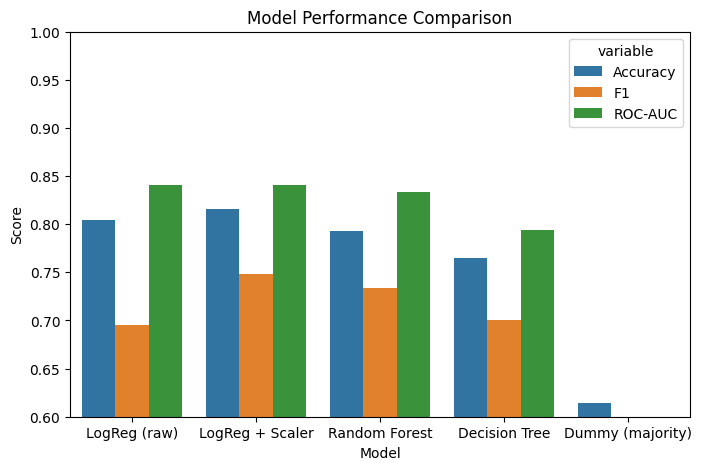

In [194]:
# Final model comparison (all models, consistent metrics)
results = pd.DataFrame([
    {"Model": "Dummy (majority)", "Accuracy": baseline_acc, "F1": 0.0,      "ROC-AUC": 0.50},
    {"Model": "LogReg (raw)",     "Accuracy": acc,          "F1": f1,       "ROC-AUC": auc},
    {"Model": "LogReg + Scaler",  "Accuracy": acc_pipe,     "F1": f1_pipe,  "ROC-AUC": auc_pipe},
    {"Model": "Decision Tree",    "Accuracy": acc_dt,       "F1": f1_dt,    "ROC-AUC": auc_dt},
    {"Model": "Random Forest",    "Accuracy": acc_rf,       "F1": f1_rf,    "ROC-AUC": auc_rf},
]).sort_values("ROC-AUC", ascending=False)

display(results)

# Barplot of metrics
plt.figure(figsize=(8,5))
sns.barplot(data=results.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.6,1)
plt.show()

### B. ROC-curve comparison

<Figure size 700x600 with 0 Axes>

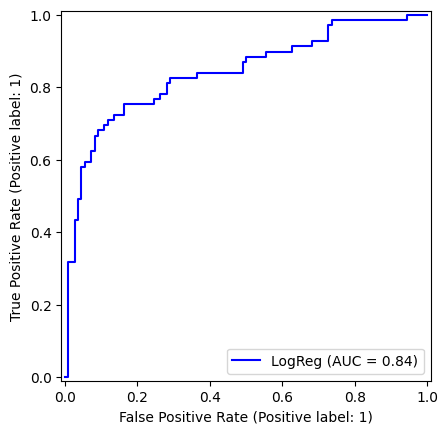

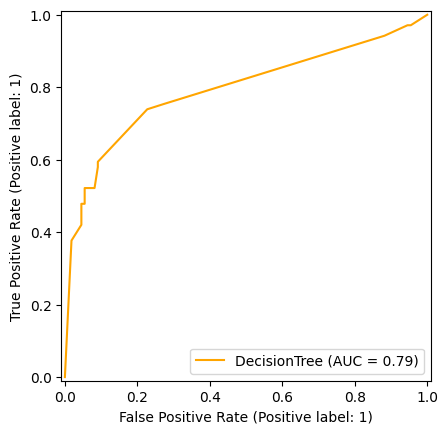

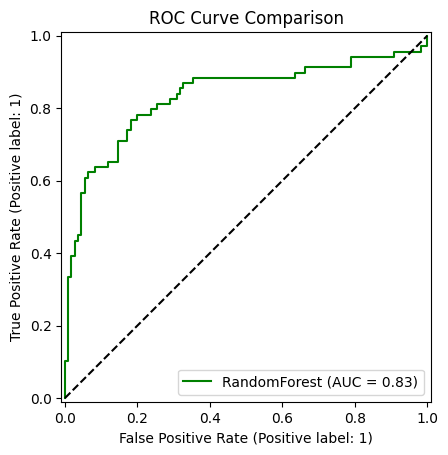

In [195]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(7,6))
RocCurveDisplay.from_estimator(pipe, X_test, y_test, name="LogReg", color="blue")
RocCurveDisplay.from_estimator(dt, X_test, y_test, name="DecisionTree", color="orange")
RocCurveDisplay.from_estimator(rf, X_test, y_test, name="RandomForest", color="green")
plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curve Comparison")
plt.show()

### C. Feature importance plots

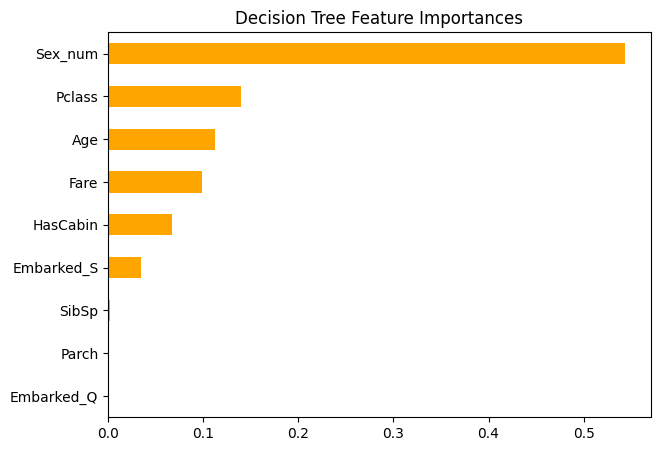

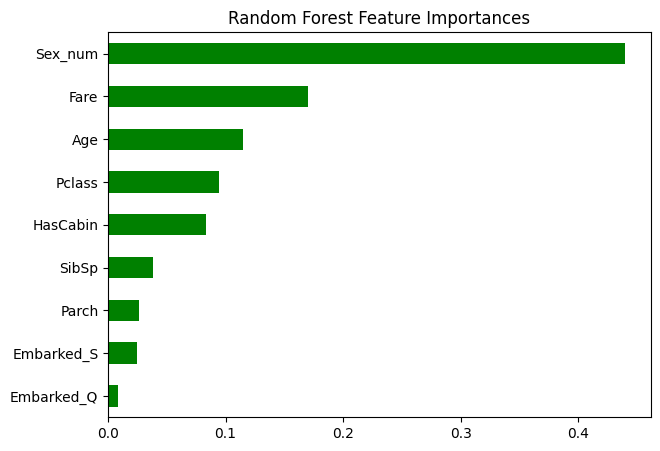

In [196]:
# Decision Tree feature importance plot
plt.figure(figsize=(7,5))
feat_imp_dt.sort_values().plot(kind="barh", color="orange")
plt.title("Decision Tree Feature Importances")
plt.show()

# Random Forest feature importance plot
plt.figure(figsize=(7,5))
feat_imp_rf.sort_values().plot(kind="barh", color="green")
plt.title("Random Forest Feature Importances")
plt.show()

## 10. Conclusion

- The **Random Forest** achieved the best overall performance (Accuracy ≈ 0.79, ROC-AUC ≈ 0.83).
- The top predictors of survival were **Sex**, **Fare**, and **Age**.
- Tree-based models captured nonlinear relationships better than Logistic Regression.
- Ensemble methods (like Random Forest) improved generalization and reduced overfitting.


## 11. Save and Load models

In [197]:
# Save each trained model
joblib.dump(pipe, "models/titanic_logreg_scaled_pipeline.joblib")
joblib.dump(dt, "models/titanic_decision_tree.joblib")
joblib.dump(rf, "models/titanic_random_forest.joblib")

print("Models saved successfully in 'models/' folder")

Models saved successfully in 'models/' folder


In [198]:
# Load and test a saved model
loaded_rf = joblib.load("models/titanic_random_forest.joblib")

# Test it on some data
sample_preds = loaded_rf.predict(X_test[:5])
sample_probs = loaded_rf.predict_proba(X_test[:5])[:, 1]

print("Sample predictions:", sample_preds)
print("Sample probabilities:", np.round(sample_probs, 3))

Sample predictions: [0 0 0 0 1]
Sample probabilities: [0.176 0.239 0.183 0.164 0.692]


### Saving and Reusing Models

We save trained models in `.joblib` format for future reuse without retraining.  
This allows deployment in apps or quick testing on new data.  
Each model can be reloaded with `joblib.load()` and used directly.
